# Examine Umbra satellite orbits

Using public space-track.org metadata (requires free account to authenticate)
https://spacetrack.readthedocs.io/

In [1]:
from spacetrack import SpaceTrackClient
import spacetrack.operators as op
import os
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import json
%matplotlib inline

In [2]:
st = SpaceTrackClient(
    os.environ.get('SPACETRACK_USER'),
    os.environ.get('SPACETRACK_PASS'),
)

In [3]:
results = st.satcat(satname=op.like('umbra'))
df = pd.DataFrame(results).sort_values('LAUNCH', ignore_index=True)
cols = ['NORAD_CAT_ID', 'SATNAME', 'LAUNCH','DECAY','SITE','PERIOD','INCLINATION','PERIGEE','APOGEE']
df[cols]

,NORAD_CAT_ID,SATNAME,LAUNCH,DECAY,SITE,PERIOD,INCLINATION,PERIGEE,APOGEE
0,48906,UMBRA-2001,2021-06-30,2024-04-30,AFETR,87.79,97.57,155,175
1,50986,UMBRA-02,2022-01-13,2024-11-08,AFETR,87.84,97.34,160,175
2,52753,UMBRA-03,2022-05-25,2024-04-08,AFETR,87.63,97.50,147,167
3,55050,UMBRA-04,2023-01-03,2024-09-03,AFETR,90.75,97.41,304,319
4,55036,UMBRA-05,2023-01-03,None,AFETR,93.67,97.37,451,457
5,56198,UMBRA-06,2023-04-15,2024-11-18,AFWTR,87.92,97.30,169,175
6,58292,UMBRA-08,2023-11-11,None,AFWTR,93.96,97.41,468,469
7,58297,UMBRA-07,2023-11-11,None,AFWTR,95.93,97.40,561,565
8,60541,UMBRA-09,2024-08-16,None,AFWTR,95.71,97.72,552,554
9,60547,UMBRA-10,2024-08-16,None,AFWTR,95.71,97.72,552,554


Notes:

- All polar orbits (inclination 97)
- First sat launched in 2021-06-30 (decayed 2024-04-30, so lasted ~3 years)
- Looks like currently 7 active satellites
- Sats 4&5, 7&8, 9&10 launched as pairs on same date
- Most > 500km perigee, so Umbra-2 at 370 & Umbra-6 maybe non-functional...

In [4]:
# Check operational status
# https://space.stackexchange.com/questions/63068/establish-if-payload-is-still-operational-space-track

def get_operational_status(norad_id):
    with urllib.request.urlopen(f'https://celestrak.org/satcat/records.php?CATNR={norad_id}') as url:
        return json.load(url)[0]['OPS_STATUS_CODE']

In [5]:
# NOTE: This sometimes give a server error...
df['OPS_STATUS_CODE'] = df.NORAD_CAT_ID.apply(get_operational_status)

In [ ]:
# Plot orbital history (just perigee)
def get_orbital_history(norad_id):
    '''returns a dataframe of all TLE solutions'''
    #results = st.gp(norad_cat_id=norad_id) # only most recent
    results = st.gp_history(norad_cat_id=norad_id)  # all TLE solutions

    df = pd.DataFrame(results)

    keep_cols = ['EPOCH','PERIAPSIS']
    df = df[keep_cols]
    df['EPOCH'] = pd.to_datetime(df.EPOCH)
    df['PERIGEE'] = df.PERIAPSIS.astype(float)

    return df

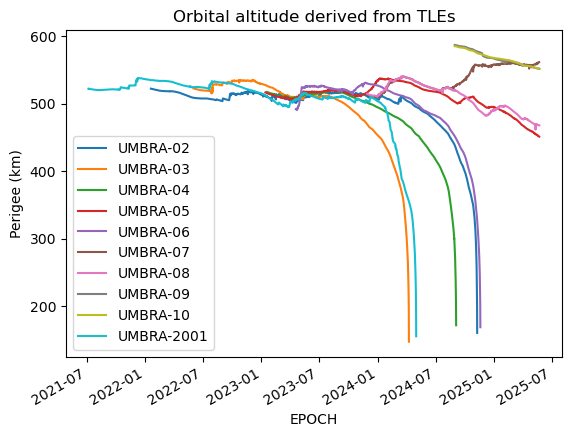

In [7]:
df.sort_values(by='SATNAME', inplace=True, ignore_index=True)
dataframes = [get_orbital_history(x) for x in df.NORAD_CAT_ID]

fig,ax = plt.subplots()

for satname, dfo in zip(df.SATNAME, dataframes):
    dfo.plot(x='EPOCH', y='PERIGEE', ax=ax, label=satname);

plt.ylabel('Perigee (km)')
plt.title('Orbital altitude derived from TLEs');

In [8]:
df.OPS_STATUS_CODE.value_counts()

OPS_STATUS_CODE
D    5
+    5
Name: count, dtype: int64

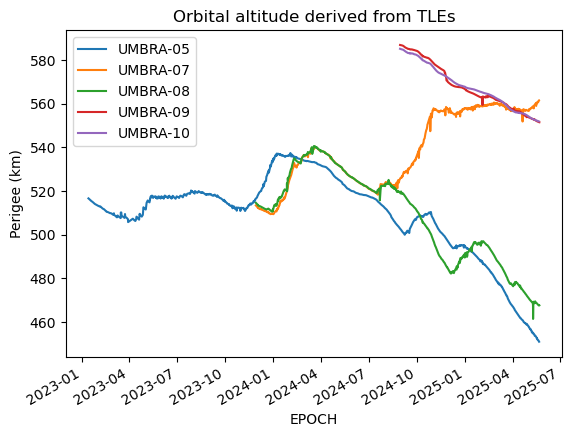

In [9]:
# Restrict to operational satellites
df = df.query('OPS_STATUS_CODE == "+"')
# 6 is not operation, but still not 'D' ops code
df = df[~(df.SATNAME == 'UMBRA-06')]
df.sort_values(by='SATNAME', inplace=True, ignore_index=True)
dataframes = [get_orbital_history(x) for x in df.NORAD_CAT_ID]
fig,ax = plt.subplots()
for satname,dfo in zip(df.SATNAME, dataframes):
    dfo.plot(x='EPOCH', y='PERIGEE', ax=ax, label=satname);

plt.ylabel('Perigee (km)')
plt.title('Orbital altitude derived from TLEs');

In [10]:
[dfo.PERIGEE.iloc[-1] for dfo in dataframes]

[np.float64(450.968),
 np.float64(561.443),
 np.float64(467.613),
 np.float64(551.457),
 np.float64(551.833)]